In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


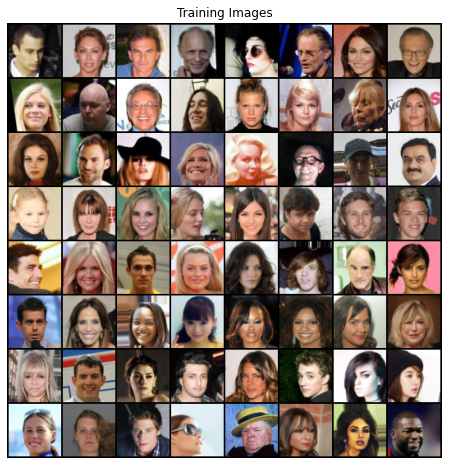

In [2]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root='/Users/ivy2021/Downloads/img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


(Weight Initialization)
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [3]:
# custom weights initialization called on Generator and Discriminator network
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Discriminator and Generator Model

In [4]:
class Generator_DCGAN(nn.Module):
    def __init__(self):
        super(Generator_DCGAN, self).__init__()
        # first set of CONVT => RELU => BN 
        # Input: BATCH_SIZE x Z_DIM(100) x 1 x 1, Output: BATCH_SIZE x 1024 x 4 x 4
        self.ct1    = nn.ConvTranspose2d(in_channels=Z_DIM,
                      out_channels=FEATURES_GEN*16, kernel_size=4, stride=1, padding=0,
                      bias=False)
        self.relu1  = nn.ReLU()
        self.bNorm1 = nn.BatchNorm2d(FEATURES_GEN*16)
        # second set of CONVT => RELU => BN
        # Input: BATCH_SIZE x 1024 x 4 x 4, Output: BATCH_SIZE x 512 x 8 x 8
        self.ct2    = nn.ConvTranspose2d(in_channels=FEATURES_GEN*16,
                      out_channels=FEATURES_GEN*8, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.relu2  = nn.ReLU()
        self.bNorm2 = nn.BatchNorm2d(FEATURES_GEN*8)
        # third set of CONVT => RELU => BN
        # Input: BATCH_SIZE x 512 x 8 x 8, Output: BATCH_SIZE x 256 x 16 x 16
        self.ct3    = nn.ConvTranspose2d(in_channels=FEATURES_GEN*8,
                      out_channels=FEATURES_GEN*4, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.relu3  = nn.ReLU()
        self.bNorm3 = nn.BatchNorm2d(FEATURES_GEN*4)
        # fourth set of CONVT => RELU => BN 
        # Input: BATCH_SIZE x 256 x 16 x 16, Output: BATCH_SIZE x 128 x 32 x 32
        self.ct4    = nn.ConvTranspose2d(in_channels=FEATURES_GEN*4,
                      out_channels=FEATURES_GEN*2, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.relu4  = nn.ReLU()
        self.bNorm4 = nn.BatchNorm2d(FEATURES_GEN*2)
        # fourth set of CONVT => RELU => BN 
        # Input: BATCH_SIZE x 128 x 32 x 32, Output: BATCH_SIZE x 3 x 64 x 64
        self.ct5    = nn.ConvTranspose2d(in_channels=FEATURES_GEN*2,
                      out_channels=CHANNELS_IMG, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.tanh   = nn.Tanh()
        
    def forward(self, x):
        # pass the input through our first set of CONVT => RELU => BN layers
        x = self.ct1(x)
        x = self.relu1(x)
        x = self.bNorm1(x)
        # second CONVT => RELU => BN layer
        x = self.ct2(x)
        x = self.relu2(x)
        x = self.bNorm2(x)
        # third CONVT => RELU => BN layer
        x = self.ct3(x)
        x = self.relu3(x)
        x = self.bNorm3(x)
        # fourth CONVT => RELU => BN layer
        x = self.ct4(x)
        x = self.relu4(x)
        x = self.bNorm4(x)
        # last layer CONVT2D => TANH
        x = self.ct5(x)
        output = self.tanh(x)

        return output

In [5]:
class Generator_MLP(nn.Module):
    def __init__(self):
        super(Generator_MLP, self).__init__()
        # Input: BATCH_SIZE x Z_DIM(100) x 1 x 1,
        self.lin1  = nn.Linear(Z_DIM, 512)
        self.relu1 = nn.ReLU()
        # second layer
        self.lin2  = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        # third layer
        self.lin3  = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        # fourth layer output image
        self.lin4  = nn.Linear(512, CHANNELS_IMG*IMAGE_SIZE*IMAGE_SIZE)
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1))
        # pass the input through 4 layers MLP with 512 hidden unit each
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin4(x)
        
        return x.view(x.size(0), CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
   

        

In [12]:
class Discriminator_DCGAN(nn.Module):
    def __init__(self, is_gan):
        super(Discriminator_DCGAN, self).__init__()
        # Input: BATCH_SIZE x CHANNELS_IMG(3) x 64 x 64
        self.is_gan = is_gan
        self.c1     = nn.Conv2d(in_channels=CHANNELS_IMG,
                      out_channels=FEATURES_CRITIC, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.Lrelu1 = nn.LeakyReLU(0.2)
        # state size. FEATURES_CRITIC x 32 x 32
        # second layer: set of Conv2D->BatchNorm2D->LeakyRelu
        self.c2     = nn.Conv2d(in_channels=FEATURES_CRITIC,
                      out_channels=FEATURES_CRITIC*2, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.bNorm1 = nn.BatchNorm2d(FEATURES_CRITIC*2)
        self.Lrelu2 = nn.LeakyReLU(0.2)
        # state size. FEATURES_CRITIC*2 x 16 x 16
        # third layer: set of Conv2D->BatchNorm2D->LeakyRelu
        self.c3     = nn.Conv2d(in_channels=FEATURES_CRITIC*2,
                      out_channels=FEATURES_CRITIC*4, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.bNorm2 = nn.BatchNorm2d(FEATURES_CRITIC*4)
        self.Lrelu3 = nn.LeakyReLU(0.2)
        # state size. FEATURES_CRITIC*4 x 8 x 8
        # fourth layer: set of Conv2D->BatchNorm2D->LeakyRelu
        self.c4     = nn.Conv2d(in_channels=FEATURES_CRITIC*4,
                      out_channels=FEATURES_CRITIC*8, kernel_size=4, stride=2, padding=1,
                      bias=False)
        self.bNorm3 = nn.BatchNorm2d(FEATURES_CRITIC*8)
        self.Lrelu4 = nn.LeakyReLU(0.2)
        # state size. FEATURES_CRITIC*8 x 4 x 4
        # last layer TO faltten output to 1x1
        self.c5     = nn.Conv2d(in_channels=FEATURES_CRITIC*8,
                      out_channels=1, kernel_size=4, stride=2, padding=0,
                      bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # input
        x = self.c1(x)
        x = self.Lrelu1(x)
        # second Conv2D->BatchNorm2D->LeakyRelu
        x = self.c2(x)
        x = self.bNorm1(x)
        x = self.Lrelu2(x)
        # third Conv2D->BatchNorm2D->LeakyRelu
        x = self.c3(x)
        x = self.bNorm2(x)
        x = self.Lrelu3(x)
        # fourth Conv2D->BatchNorm2D->LeakyRelu
        x = self.c4(x)
        x = self.bNorm3(x)
        x = self.Lrelu4(x)
        # last layer Conv2D
        output = self.c5(x)
        if self.is_gan:
            output = self.sigmoid(output)

        return output

In [7]:
class Discriminator_MLP(nn.Module):
    def __init__(self):
        super(Discriminator_MLP, self).__init__()
        # Input: BATCH_SIZE x CHANNELS_IMG(3) x 64 x 64
        self.lin1  = nn.Linear(CHANNELS_IMG*IMAGE_SIZE*IMAGE_SIZE, 512)
        self.relu1 = nn.ReLU()
        # second layer
        self.lin2  = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        # third layer
        self.lin3  = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        # fourth layer output value of realness/fakeness
        self.lin4  = nn.Linear(512, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        # pass the input through 4 layers MLP with 512 hidden unit each
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin4(x)
        x = x.mean(0)
        return x.view(1)

WGAN Training 

In [16]:
#building generator
#gen = Gnerator_DCGAN()
gen = Generator_MLP() 
gen.apply(weights_init)
gen.to(device)
#building critics
#critic = Discriminator_DCGAN(0)
critic = Discriminator_MLP()
critic.apply(weights_init)
critic.to(device)
# initializate optimizer
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE) #Line 6 Algorithm1 
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE) #Line 11 Algorithm1 


#writer_real = SummaryWriter(f"logs/real")
#writer_fake = SummaryWriter(f"logs/fake")
#writer = SummaryWriter("runs/)

step = 0
G_losses = []
D_losses = []

#set model mode to train
gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data[].to(device)
        cur_batch_size = data.shape[0]
        
        #Algorithm 1
        # train critic for ncritic times: the number of iterations of the critic per generator iteration
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            #Line 3 trained generator generate fake image from noise
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            #line 5 
            #max (E[critic(real)] - E[critic(fake)]) = min (-(E[critic(real)] - E[critic(fake)]))
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            #Line 6
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # line 7, clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        
        #line 9 Train Generator
        gen_fake = critic(fake).reshape(-1)
        #Line 10 max (E[critic(gen_fake)]) = min (-E[critic(gen_fake)])
        loss_gen = -torch.mean(gen_fake)
        #Line 11
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
            D_losses.append(loss_critic.item())
            G_losses.append(loss_gen.item())

            with torch.no_grad():
                fake = gen(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
                vutils.save_image(img_grid_real, f"/Users/ivy2021/Documents/WGAN_MLP/real_{epoch}_{batch_idx}.png")
                vutils.save_image(img_grid_fake, f"/Users/ivy2021/Documents/WGAN_MLP/fake_{epoch}_{batch_idx}.png")
                #writer.add_image("Real", img_grid_real, global_step=step)
                #writer.add_image("Fake", img_grid_fake, global_step=step)
                #writer.flush()
            step += 1
            gen.train()
            critic.train()

Epoch [0/5] Batch 100/3166                   Loss D: -107.0359, loss G: 2.1944


KeyboardInterrupt: 

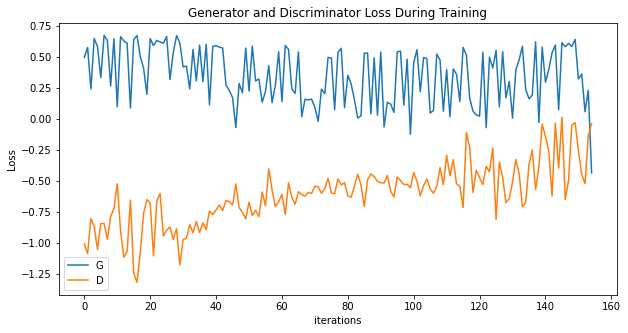

In [34]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


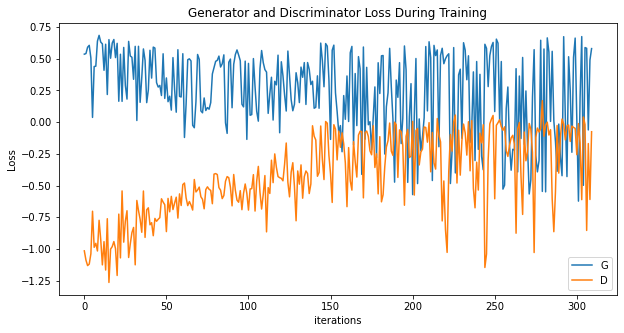

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

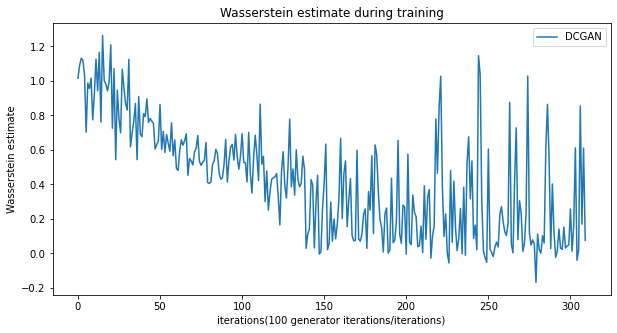

In [42]:
plt.figure(figsize=(10,5))
plt.title("Wasserstein estimate during training")
W_est = [ -x for x in D_losses]
plt.plot(W_est,label="DCGAN")
plt.xlabel("iterations(100 generator iterations/iterations)")
plt.ylabel("Wasserstein estimate")
plt.legend()
plt.show()

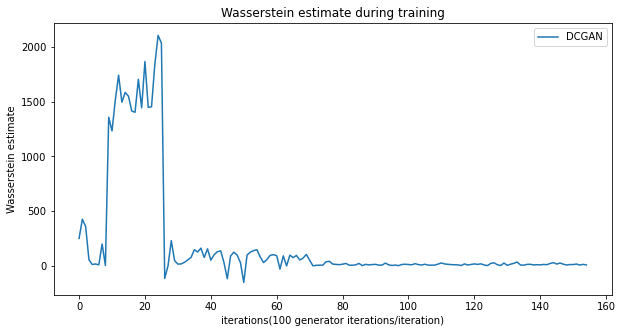

In [56]:
plt.figure(figsize=(10,5))
plt.title("Wasserstein estimate during training")
W_est = [ -x for x in D_losses]
plt.plot(W_est,label="DCGAN")
plt.xlabel("iterations(100 generator iterations/iteration)")
plt.ylabel("Wasserstein estimate")
plt.legend()
plt.show()

GAN Training (for comparison)

In [19]:
CUDA_LAUNCH_BLOCKING=1
criterion = nn.BCELoss()
num_epochs = 10
lr = 0.0002




# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#building generator
gen = Generator_DCGAN() 
gen.apply(weights_init)
gen.to(device)
#building critics
disc = Discriminator_DCGAN(is_gan=1)
disc.apply(weights_init)
disc.to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0




print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for batch_idx, (data, _) in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        CUDA_LAUNCH_BLOCKING=1
        real = data.to(device)
        CUDA_LAUNCH_BLOCKING=1
        cur_batch_size = data.shape[0]
        label = torch.full((cur_batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if batch_idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, batch_idx, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise).detach().cpu()
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
                vutils.save_image(img_grid_real, f"/Users/ivy2021/Documents/GAN/real_{epoch}_{iters}.png")
                vutils.save_image(img_grid_fake, f"/Users/ivy2021/Documents/GAN/fake_{epoch}_{iters}.png")

        iters += 1

Starting Training Loop...
[0/10][0/3166]	Loss_D: 1.7449	Loss_G: 2.3920	D(x): 0.4902	D(G(z)): 0.5130 / 0.1117
[0/10][50/3166]	Loss_D: 0.0208	Loss_G: 7.9923	D(x): 0.9976	D(G(z)): 0.0179 / 0.0006
[0/10][100/3166]	Loss_D: 0.6176	Loss_G: 11.2684	D(x): 0.9968	D(G(z)): 0.3594 / 0.0004
[0/10][150/3166]	Loss_D: 0.1119	Loss_G: 4.6369	D(x): 0.9702	D(G(z)): 0.0698 / 0.0203
[0/10][200/3166]	Loss_D: 0.3483	Loss_G: 2.4984	D(x): 0.8363	D(G(z)): 0.1122 / 0.1153
[0/10][250/3166]	Loss_D: 0.9769	Loss_G: 1.8898	D(x): 0.7420	D(G(z)): 0.2760 / 0.2519
[0/10][300/3166]	Loss_D: 0.8601	Loss_G: 1.6247	D(x): 0.6040	D(G(z)): 0.1007 / 0.2874
[0/10][350/3166]	Loss_D: 0.4114	Loss_G: 3.5822	D(x): 0.7568	D(G(z)): 0.0639 / 0.0462
[0/10][400/3166]	Loss_D: 0.5246	Loss_G: 3.2501	D(x): 0.7458	D(G(z)): 0.1350 / 0.0673
[0/10][450/3166]	Loss_D: 0.5156	Loss_G: 3.7227	D(x): 0.8292	D(G(z)): 0.1912 / 0.0482
[0/10][500/3166]	Loss_D: 0.8388	Loss_G: 2.3676	D(x): 0.5948	D(G(z)): 0.0689 / 0.1773
[0/10][550/3166]	Loss_D: 2.5170	Loss_G: 2

NameError: name 'i' is not defined

In [65]:
print(device)

cuda:0


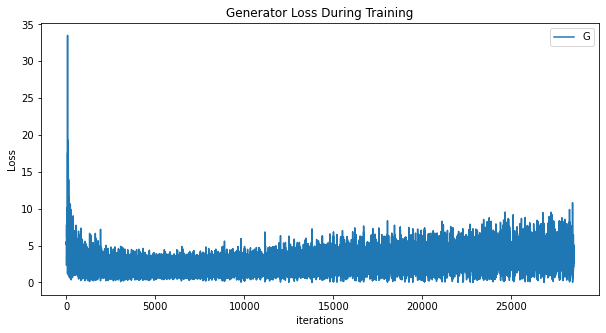

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses,label="G")
#plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()